In [1]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


 Import libraries

In [29]:
# Standard python libraries
import collections
# Scientific python
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
# Great progress bar
import tqdm.auto as tqdm
# ML: UMAP and PCA
import umap
import umap.umap_ as umap
import sklearn.decomposition
# Our DL stack
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as torch_data

print(torch.__version__)

1.13.1


# Get data

https://www.kaggle.com/datasets/zalando-research/fashionmnist


* Transforms are used to convert the images into 2D tensors in a $[0,1]$ numerical range.
* Dataset is split in train and test set.

In [11]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 10778786.91it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 296252.14it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4780272.80it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5156980.41it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [12]:
batch_size = 64
train_loader = torch_data.DataLoader(train_dataset, batch_size=batch_size,
                                     shuffle=True)
test_loader = torch_data.DataLoader(test_dataset, batch_size=batch_size,
                                    shuffle=False)

# Exploratory data analysis


Extremely **important and underappriciated** part of any ML task.

* What does the data look like?
    * How big is it?
    * Inputs? How complex is it?
    * Outputs? What does the distribution look like?
* Do I need ML to solve the problem?
* A good rule of thumb: If you can "visually" solve it, you might not need fancy ML.

In [13]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = sns.color_palette('Set3', len(class_names))
print("Number of training samples:", len(train_dataset))
print("Number of test samples:    ", len(test_dataset))
print(class_names)
colors

Number of training samples: 60000
Number of test samples:     10000
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353)]

Sample Images from the Training Set:


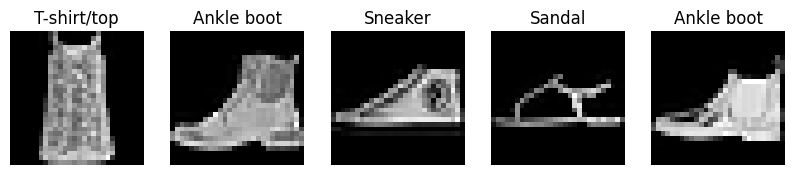

In [14]:
def show_images(dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = images[i].squeeze().numpy()
        plt.imshow(img, cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

print("Sample Images from the Training Set:")
show_images(train_loader)

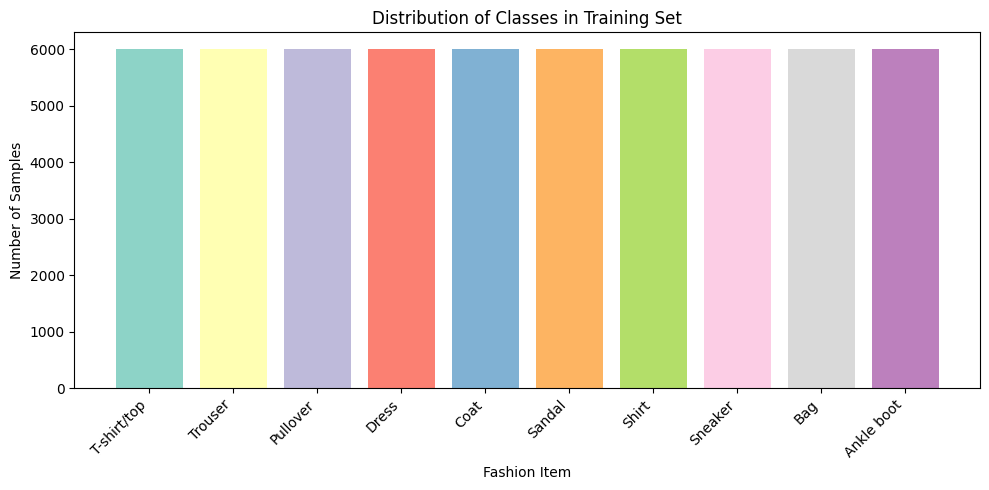

In [15]:
train_labels = [label for _, label in train_dataset]
label_counts = collections.Counter(train_labels)
counts = list(label_counts.values())
plt.figure(figsize=(10, 5))
plt.bar(class_names, counts, color=colors)
plt.xlabel("Fashion Item")
plt.ylabel("Number of Samples")
plt.title("Distribution of Classes in Training Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Let's visualize data and labels with dimensionality reduction

First we use PCA, principle components analysis which will return the two dimensions of highest variability via a linear transformation.

In [16]:
x = train_dataset.data.numpy().reshape(len(train_dataset), -1)
y = np.array(train_labels)
pca = sklearn.decomposition.PCA(n_components=2)
embedding = pca.fit_transform(x)

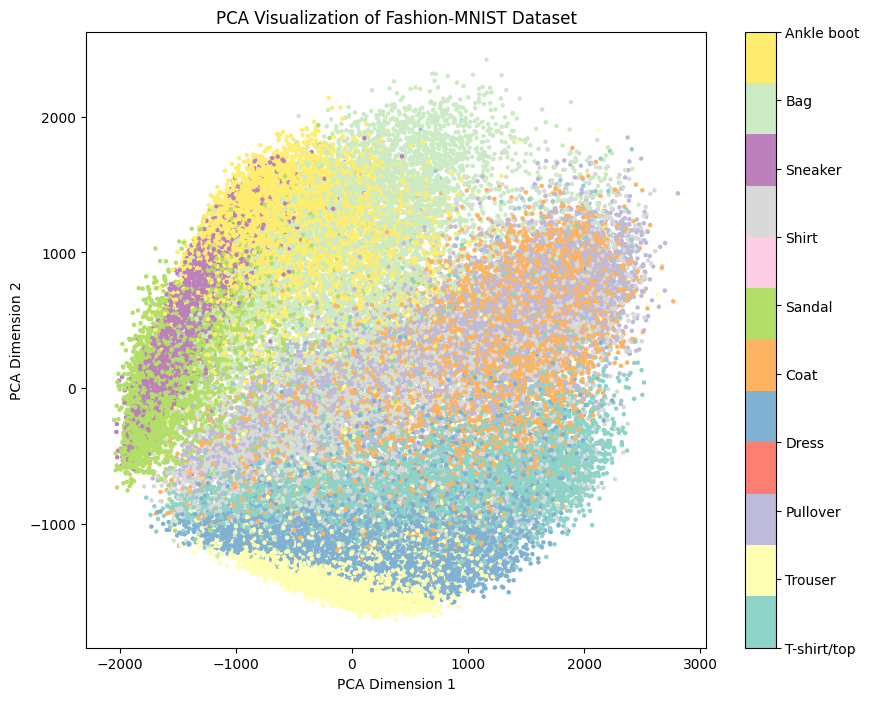

In [17]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Set3', s=5)
plt.title('PCA Visualization of Fashion-MNIST Dataset')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.colorbar(scatter, ticks=np.arange(len(class_names)),
             format=plt.FuncFormatter(lambda i, *args: class_names[int(i)]))
plt.show()

We could also use UMAP, an advanced dimentionality reduction technique, always be cause when using it.

A good guide to understand some of nuances is: https://pair-code.github.io/understanding-umap/

In [30]:
reducer = umap.UMAP(verbose=True)
embedding = reducer.fit_transform(x)

UMAP( verbose=True)
Wed Feb 19 19:29:13 2025 Construct fuzzy simplicial set
Wed Feb 19 19:29:13 2025 Finding Nearest Neighbors
Wed Feb 19 19:29:13 2025 Building RP forest with 17 trees
Wed Feb 19 19:29:22 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Wed Feb 19 19:29:42 2025 Finished Nearest Neighbor Search
Wed Feb 19 19:29:47 2025 Construct embedding


Epochs completed:   2%| ▎          5/200 [00:03]

	completed  0  /  200 epochs


Epochs completed:  12%| █▏         23/200 [00:04]

	completed  20  /  200 epochs


Epochs completed:  22%| ██▎        45/200 [00:05]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▏       63/200 [00:06]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▏      83/200 [00:07]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▏     104/200 [00:08]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▎    125/200 [00:09]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▏   143/200 [00:09]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▏  164/200 [00:10]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▎ 185/200 [00:11]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:12]


Wed Feb 19 19:30:04 2025 Finished embedding


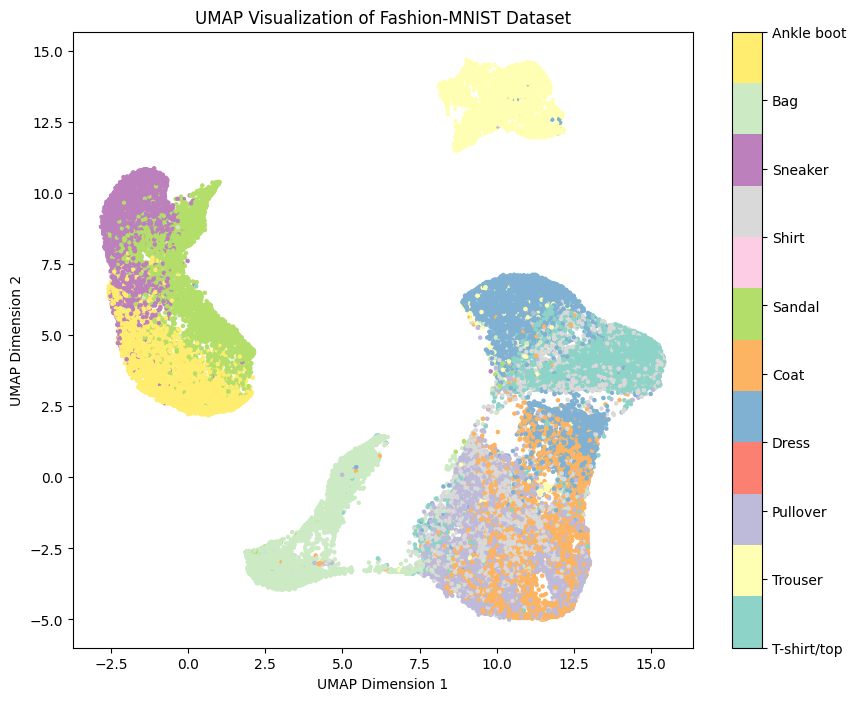

In [32]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Set3', s=5)
plt.title('UMAP Visualization of Fashion-MNIST Dataset')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(scatter, ticks=np.arange(len(class_names)),
             format=plt.FuncFormatter(lambda i, *args: class_names[int(i)]))
plt.show()

# Setting up a model class

Let's define a simple 2-layer MLP

In [33]:
class MLP(nn.Module):
    """Multilayer Perceptron (MLP) model."""

    def __init__(self, input_size:int, hidden_size:int, num_classes:int):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.predict = nn.Linear(hidden_size, num_classes)

    def get_embedding(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        return x

    def forward(self, x):
        x = self.get_embedding(x)
        x = self.predict(x)
        return x

We create the model based on some hyper-parameters

In [34]:
input_size = 28 * 28
hidden_size = 100
num_classes = len(class_names)
model = MLP(input_size, hidden_size, num_classes)
print("Model Architecture:")
print(model)

Model Architecture:
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (predict): Linear(in_features=100, out_features=10, bias=True)
)


We then decide how to optimize our model:
* Loss function: CrossEntropy, for integer encoded categorical variables.
* Optimizer: (Adam), a good default for DL models, learning rate is the most crucial.

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
num_epochs = 10
pbar = tqdm.tqdm(range(num_epochs))
for epoch in pbar:
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    pbar.set_postfix({'loss':running_loss/i})

100%|██████████| 10/10 [02:42<00:00, 16.29s/it, loss=0.25]


Let's tell the model we will stop training and just "evaluate"

In [37]:
model.eval()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (predict): Linear(in_features=100, out_features=10, bias=True)
)

In [38]:
example_images, example_labels = next(iter(test_loader))
with torch.no_grad():
    example_outputs = model(example_images)
    example_predictions = torch.argmax(example_outputs, 1)
    example_embeddings = model.get_embedding(example_images)
print(f'Example outputs: {example_outputs.shape}')
print(f'Example predictions: {example_predictions.shape}')
print(f'Example embeddings: {example_embeddings.shape}')

Example outputs: torch.Size([64, 10])
Example predictions: torch.Size([64])
Example embeddings: torch.Size([64, 100])


How good is the model? (evaluate)

In [39]:
correct = 0
total = len(test_dataset)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        predicted = torch.argmax(outputs.data, 1)
        correct += (predicted == labels).sum().item()
print(f'Accuracy (test): {100 * correct / total}%')

Accuracy (test): 88.06%


Let compute embeddings visualize the representation that we learned

In [40]:
embedding_list = []
test_label_list = []
with torch.no_grad():
    for images, labels in test_loader:
        embeddings = model.get_embedding(images)
        embedding_list.extend(embeddings.numpy())
        test_label_list.extend(labels.numpy())

embeddings = np.array(embedding_list)
test_labels = np.array(test_label_list)
pca = sklearn.decomposition.PCA(n_components=2)
embeddings2d = pca.fit_transform(embeddings)
print(f'Reduce {embeddings.shape} to {embeddings2d.shape} via PCA')

Reduce (10000, 100) to (10000, 2) via PCA


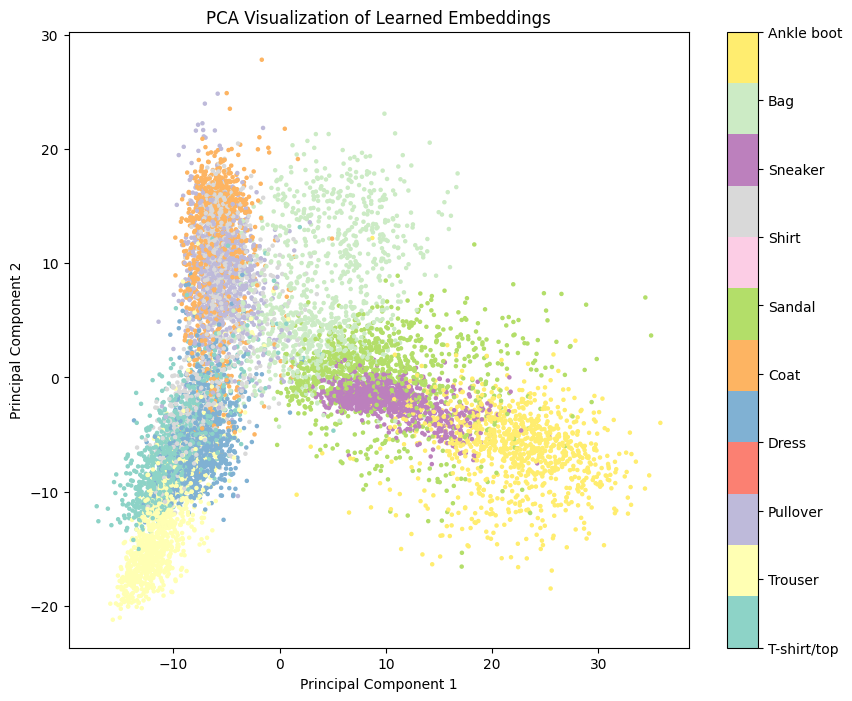

In [41]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings2d[:, 0], embeddings2d[:, 1], c=test_labels, cmap='Set3', s=5)
plt.title('PCA Visualization of Learned Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
colorbar = plt.colorbar(scatter, ticks=np.arange(len(class_names)))
colorbar.ax.set_yticklabels(class_names)
plt.show()